In [1]:
# set cwd and solver
import os
import cobra
cobra.Configuration().solver = "gurobi"
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') 

In [2]:
# load combined RPE_PR models
from pathlib import Path
from cobra.io import read_sbml_model

mod_RPE_PR = read_sbml_model(Path().cwd() / "models" / "mod_RPE_PR.xml")
mod_RPE_PR.id = 'RPE_PR_old'
mod_RPE_PR.name = 'RPE_PR_old'
mod_Human1_Human1 = read_sbml_model(Path().cwd() / "models" /  "mod_Human1_Human1.xml")
mod_Human1_Human1.id = 'RPE_PR_control_old'
mod_Human1_Human1.name = 'RPE_PR_control_old'
mod = read_sbml_model(Path().cwd() / 'models/Human-GEM.xml')
mod.id = 'Human1_old'
mod.name = 'Human1_old'  

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03


In [3]:
# load all models in \cs_mods\July2023 folder by cycling through names
from cobra.io import read_sbml_model    
import glob 
import os   

os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR/cs_mods/July2023') # set cwd
model_list = []
for file in glob.glob("*.xml"):  
    model = read_sbml_model(file)
    model.id = file[:-4] # remove .xml 
    model.name = file[:-4] # remove .xml
    model_list.append(model)
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') # reset cwd

No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


In [4]:
# add old models to model_list
model_list = model_list + [mod,mod_RPE_PR]

# check out model_list
model_list

[<Model Human-GEM_28062023 at 0x2e93a467400>,
 <Model mod_RPE_PRcone_Liang at 0x2e93f573c70>,
 <Model mod_RPE_PRcone_Liang_singlePR at 0x2e9487eefe0>,
 <Model mod_RPE_PRcone_Liang_singleRPE at 0x2e94a2747f0>,
 <Model mod_RPE_PRcone_Lukowski at 0x2e94820ca00>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x2e956644ee0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x2e959b4e110>,
 <Model mod_RPE_PRcontrol at 0x2e95f48fca0>,
 <Model mod_RPE_PRrod_Liang at 0x2e97c012740>,
 <Model mod_RPE_PRrod_Liang_singlePR at 0x2e981ddf6d0>,
 <Model mod_RPE_PRrod_Liang_singleRPE at 0x2e9840a2ce0>,
 <Model mod_RPE_PRrod_Lukowski at 0x2e9881cd690>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x2e98fbf6ef0>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x2e9931cb9d0>,
 <Model Human1_old at 0x2e8e5382cb0>,
 <Model RPE_PR_old at 0x2e8f5719540>]

In [5]:
# for all models in the list set objective function (ATP hydrolysis, in PR for combined models)

for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

In [6]:
# list combined and single models
combined_models = [m for m in model_list if 'single' not in m.id]
single_models = [m for m in model_list if 'single' in m.id]

# close PR exchange in combined models and open RPE exchange (efflux)
for m in combined_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,0)
    for r in [r for r in m.reactions if len(r.products) == 0 if '_RPE' in r.id]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000) 

# only allow efflux exchange in single models
for m in single_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,1000)

# for Human1 models, open efflux
for m in [m for m in model_list if 'Human' in m.id]:
    for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000)

In [7]:
# dark new estimates
# MAR09048 = oxygen exchange
# MAR09034 = glucose exchange
# MAR09135 = lactate exchange

def set_bound(model, ex_dict): 
    """set bounds for exchange reactions in model based on dict"""
    for ex in ex_dict.keys():
        if ex + '_RPE' in [r.id for r in model.reactions]:
            model.reactions.get_by_id(ex + '_RPE').bounds = ex_dict[ex]
        elif ex + '_PR' in [r.id for r in model.reactions]:
            model.reactions.get_by_id(ex + '_PR').bounds = ex_dict[ex]
        elif ex + '_eRPE_PR' in [r.id for r in model.reactions]:
            model.reactions.get_by_id(ex + '_eRPE_PR').bounds = ex_dict[ex]
        elif ex in [r.id for r in model.reactions]:
            model.reactions.get_by_id(ex).bounds = ex_dict[ex]
        else:  
            print('no exchange reaction for ' + ex + ' in model: ' + model.id)
    return model


ex_bounds = {'MAR09048':(-3.51,1000),'MAR09034':(-4.18,1000),'MAR09135':(7.25,1000)}

for m in model_list:
    set_bound(m, ex_bounds)

import pandas as pd
results_dict = {}
for m in model_list:
    m.optimize()
    results_dict[m.id] = m.objective.value
df1 = pd.DataFrame(results_dict, index = ['max ATP hydrolysis (pmol/s/mm^2)']).T
df1


,max ATP hydrolysis (pmol/s/mm^2)
Human-GEM_28062023,24.7325
mod_RPE_PRcone_Liang,23.9000
mod_RPE_PRcone_Liang_singlePR,11.1350
mod_RPE_PRcone_Liang_singleRPE,23.9000
mod_RPE_PRcone_Lukowski,24.7325
mod_RPE_PRcone_Lukowski_singlePR,22.2350
mod_RPE_PRcone_Lukowski_singleRPE,23.9000
mod_RPE_PRcontrol,24.7325
mod_RPE_PRrod_Liang,23.9000
mod_RPE_PRrod_Liang_singlePR,13.9100


In [144]:
df2.to_clipboard()

In [8]:
# single if 'single', 'Human-GEM_28062023', or 'Human1_old' in df1.index else 'combined'
index1= ['single' if 'single' in x \
        or 'Human-GEM_28062023' in x \
        or 'Human1_old' in x \
        else 'combined' for x in list(df1.index)]

# 'Lukowski'if in df1.index, 'Liang' if in df1.index, Human1 if in df1.index else ''
index2 = ['Lukowski' if 'Lukowski' in x \
        else 'Liang' if 'Liang' in x \
        else 'none' if 'Human' or 'control' in x \
        else 'Liang' for x in list(df1.index)]

# 'cone'if ends with cone in df1.index, 'rod' if ends with PR and contains rod in df1.index, RPE if ends with RPE df1.index, Human1 if Human1 in df1.index, else 'RPE-PR
index3 = ['cone' if x.endswith('PR') and 'cone' in x \
        else 'rod' if x.endswith('PR') and 'rod' in x \
        else 'RPE' if x.endswith('RPE') \
        else 'Human1' if 'Human1_old' in x \
        else 'Human1' if 'Human-GEM_28062023' in x \
        else 'Human1-Human1' if 'control'in x \
        else 'Human1-Human1' if 'RPE_PR_old'in x
        else 'RPE-PR rod' if 'RPE_PRrod' in x\
        else 'RPE-PR cone' if 'RPE_PRcone' in x\
        else 'RPE-PR rod' for x in list(df1.index)]


x_ticks = [1 if 'Human' in x \
        else 2 if x is 'RPE' \
        else 3 if 'cone' in x \
        else 4 if 'rod' in x \
        else '' for x in index3]

index = pd.DataFrame([x_ticks,index1, index2, index3]).T

# add index as new index to df1
df2 = pd.concat([index,df1.reset_index()], axis=1)
df2.columns = ['xticks','type','PR_data','cell','model_name','max ATP hydrolysis (pmol/s/mm^2)']
df2_combined = df2[df2['type'] == 'combined']
df2_single = df2[df2['type'] == 'single']
df2




<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\prins\AppData\Local\Temp\ipykernel_26644\406377762.py:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
  else 2 if x is 'RPE' \


,xticks,type,PR_data,cell,model_name,max ATP hydrolysis (pmol/s/mm^2)
0,1,single,none,Human1,Human-GEM_28062023,24.7325
1,3,combined,Liang,RPE-PR cone,mod_RPE_PRcone_Liang,23.9000
2,3,single,Liang,cone,mod_RPE_PRcone_Liang_singlePR,11.1350
3,2,single,Liang,RPE,mod_RPE_PRcone_Liang_singleRPE,23.9000
4,3,combined,Lukowski,RPE-PR cone,mod_RPE_PRcone_Lukowski,24.7325
5,3,single,Lukowski,cone,mod_RPE_PRcone_Lukowski_singlePR,22.2350
6,2,single,Lukowski,RPE,mod_RPE_PRcone_Lukowski_singleRPE,23.9000
7,1,combined,none,Human1-Human1,mod_RPE_PRcontrol,24.7325
8,4,combined,Liang,RPE-PR rod,mod_RPE_PRrod_Liang,23.9000
9,4,single,Liang,rod,mod_RPE_PRrod_Liang_singlePR,13.9100


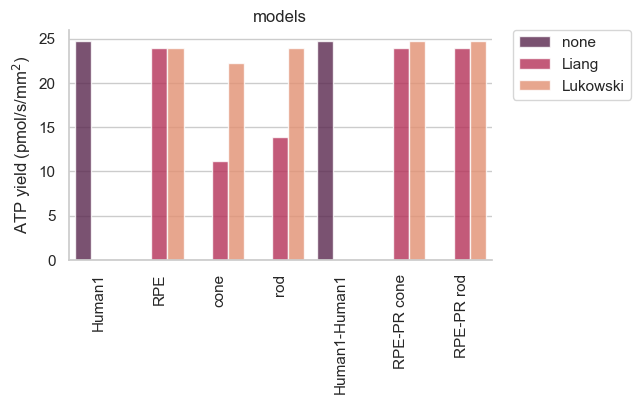

In [9]:
# plot results with seaborn catplot

# FIG
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


# change order of bars in plot to Human1, Human1 (old), RPE, cone, rod make sure to have seperate bars for each datapoint
g_all = sns.catplot(
    data=df2, kind="bar",
    x="cell", y="max ATP hydrolysis (pmol/s/mm^2)", hue="PR_data", 
    order = ['Human1','RPE','cone','rod','Human1-Human1','RPE-PR cone','RPE-PR rod'],
     palette="rocket", alpha=.8, height=4,
)
g_all.despine(left=False)
g_all.set_axis_labels("","ATP yield (pmol/s/mm$^{2}$)")
g_all.legend.set_title("expression data")
# rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plot title
plt.title('models')

#remove one of the two legends
g_all._legend.remove()
g_all.legend.set_title("expression data")

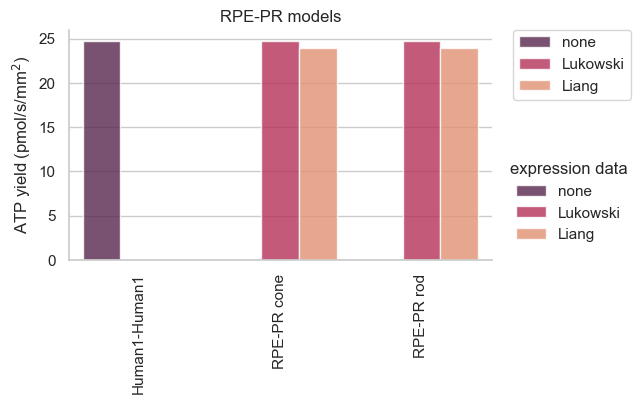

In [10]:
# plot results with seaborn catplot

# FIG
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# select only combined models
df2_combined = df2[df2['type'] == 'combined']

# change order of bars in plot to Human1, Human1 (old), RPE, cone, rod make sure to have seperate bars for each datapoint
g_combined = sns.catplot(
    data=df2_combined, kind="bar",
    x="cell", y="max ATP hydrolysis (pmol/s/mm^2)", hue="PR_data", hue_order=['none','Lukowski','Liang'],
    order = ['Human1-Human1','RPE-PR cone','RPE-PR rod'],
     palette="rocket", alpha=.8, height=4,
)
g_combined.despine(left=False)
g_combined.set_axis_labels("","ATP yield (pmol/s/mm$^{2}$)")

# rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plot title
plt.title('RPE-PR models')

#remove one of the two legends
g_combined.legend.set_title("expression data")
    

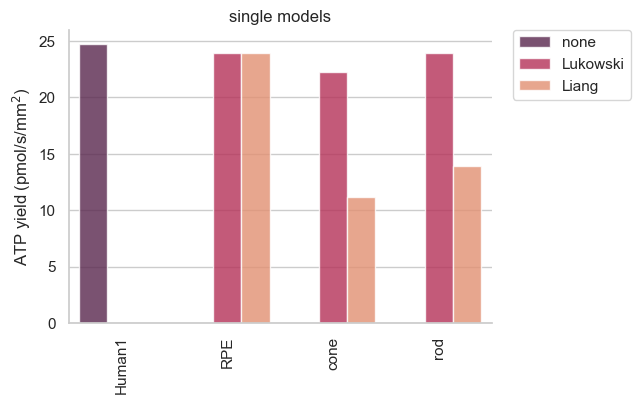

In [11]:
# plot results with seaborn catplot

# FIG
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# select only combined models
df2_single = df2[df2['type'] == 'single']

# change order of bars in plot to Human1, Human1 (old), RPE, cone, rod make sure to have seperate bars for each datapoint
g_single = sns.catplot(
    data=df2_single, kind="bar",
    x="cell", y="max ATP hydrolysis (pmol/s/mm^2)", hue="PR_data", hue_order=['none','Lukowski','Liang'],
    order = ['Human1','RPE','cone','rod'],
     palette="rocket", alpha=.8, height=4,
)
g_single.despine(left=False)
g_single.set_axis_labels("","ATP yield (pmol/s/mm$^{2}$)")

# rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plot title
plt.title('single models')

#remove one of the two legends
g_single._legend.remove()
g_single.legend.set_title("expression data")
    

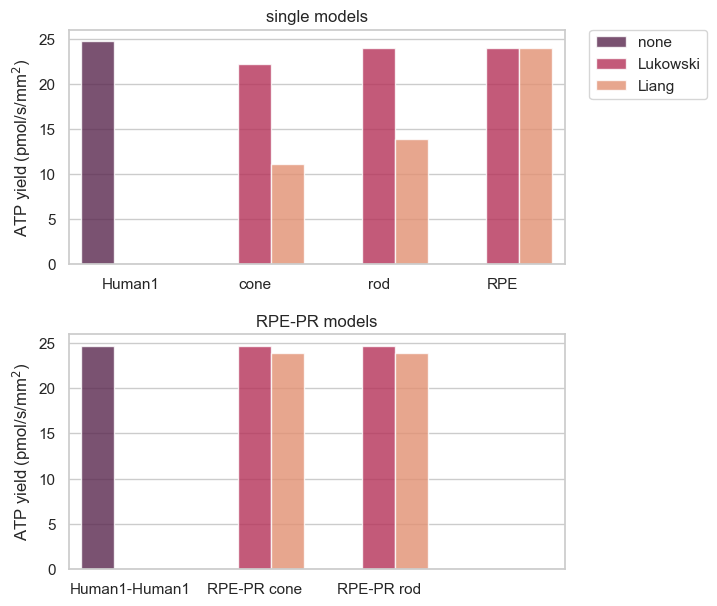

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# set up figure with two subplots
fig, axs = plt.subplots(nrows=2)    
# increase height of figure
fig.set_figheight(7)

# plot results with seaborn barplot (SINGLE MODELS)
sns.barplot(x='cell', 
            y='max ATP hydrolysis (pmol/s/mm^2)',
             data=df2_single, 
             ax=axs[0], 
             hue='PR_data',
            hue_order=['none','Lukowski','Liang'], 
            order = ['Human1','cone','rod','RPE'], 
            palette="rocket", alpha=.8, )

axs[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plot results with seaborn barplot (COMBINED MODELS)
sns.barplot(x='cell', 
            y='max ATP hydrolysis (pmol/s/mm^2)', 
            data=df2_combined, ax=axs[1], 
            hue="PR_data", 
            hue_order=['none','Lukowski','Liang'], 
            order = ['Human1-Human1','RPE-PR cone','RPE-PR rod'],
            palette="rocket", alpha=.8, )

# make bars same width for both subplots
axs[1].set_xlim(axs[0].get_xlim())

# move legend outside of plot
axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# add axis titles
axs[0].set_title('single models')
axs[1].set_title('RPE-PR models')
# add y-axis label
axs[0].set_ylabel('ATP yield (pmol/s/mm$^{2}$)')
axs[1].set_ylabel('ATP yield (pmol/s/mm$^{2}$)')
# remove x-axis label
axs[0].set_xlabel('')
axs[1].set_xlabel('')
#increase space between subplots
plt.subplots_adjust(hspace=0.3)
# remove one of the two legends using  get_legend().remove()
axs[1].get_legend().remove()


In [172]:
# function

def sample(models, n_samples):
    """
    
    Sample the flux space of a model.

    Parameters
    ----------
    models : list
        A list of cobra.Model objects.
    n_samples : int
        The number of samples to generate.

    returns
    -------

    df_sampling_results : dataframe
        A dataframe with the results of the sampling.
        
    """

    # sampling of the flux space
    from cobra.sampling import sample

    # empty dict to store results
    results_dict = {}
    for m in models:
        # print name of model being samples
        print(m.id)
        # print name objective function
        print(m.objective)
        # sample model
        s = sample(m, n_samples)
        # record results in dict
        results_dict[m.id] = s.T

    # convert dict to dataframe
    df_sampling_results = pd.concat(results_dict, axis=1)
    return df_sampling_results

def fva(models):
    """
    RPE_PR data
    Perform flux variability analysis on a list of models.

    Parameters
    ----------
    models : list
        A list of cobra.Model objects.

    returns
    -------
    df_fva_results : dataframe
        A dataframe with the results of the flux variability analysis.

    """

    # flux variability analysis
    from cobra.flux_analysis import flux_variability_analysis

    # empty dict to store results
    results_dict = {}
    for m in models:
        # print name of model being samples
        print(m.id)
        # print name objective function
        print(m.objective)
        # do loopless flux variability analysis on m
        fva_loopless = flux_variability_analysis(m, fraction_of_optimum=0.9, loopless=True)
        fva = flux_variability_analysis(m, fraction_of_optimum=0.9, loopless=False)
        # add '_loopless' to column names
        fva_loopless.columns = [str(col) + '_loopless' for col in fva_loopless.columns]
        # merge fva and fva_loopless horizontally, match index
        fva_combined = fva.merge(fva_loopless, left_index=True, right_index=True)

        # record results in dict
        results_dict[m.id] = fva_combined.T

        # convert dict to dataframe
        df_fva_results = pd.concat(results_dict, axis=1)
    return df_fva_results

def fba(models):
    """

    Perform flux balance analysis on a list of models.

    Parameters
    ----------
    models : list
        A list of cobra.Model objects.

    returns
    -------
    fba : dataframe
        A dataframe with the results of the flux balance analysis.
    
    """
    from cobra.flux_analysis.loopless import add_loopless, loopless_solution
    
    # empty dict to store results
    results_dict = {}
    
    for m in models:
        # FBA
        fba = m.optimize()
        # get fluxes and rename column
        fba = pd.DataFrame(fba.to_frame()['fluxes']).rename(columns={'fluxes':'fba'})

        # FBA
        fba = m.optimize()
        # get fluxes and rename column
        fba = pd.DataFrame(fba.to_frame()['fluxes']).rename(columns={'fluxes':'fba'})

        # FBA loopless
        fba_loopless = loopless_solution(m)
        fba_loopless = pd.DataFrame(fba_loopless.fluxes)
        # rename column
        fba_loopless = fba_loopless.rename(columns={'fluxes':'fba_loopless'})
        fba_loopless

        # merge fba and loopless
        fba = fba.merge(fba_loopless, left_index=True, right_index=True)

        # record results in dict
        results_dict[m.id] = fba

    # convert dict to dataframe
    fba = pd.concat(results_dict, axis=1)
    return fba

In [169]:
# test sampling function
df_sampling_results = sample([single_models[3]], 1)
df_sampling_results

mod_RPE_PRcone_Lukowski_singleRPE
Maximize
1.0*MAR03964_RPE - 1.0*MAR03964_RPE_reverse_dc7af
Read LP format model from file C:\Users\prins\AppData\Local\Temp\tmp4rf9os5g.lp
Reading time = 0.03 seconds
: 7186 rows, 19650 columns, 65508 nonzeros


,mod_RPE_PRcone_Lukowski_singleRPE
,0
MAR03905_RPE,-3.576006e-19
MAR03907_RPE,1.394690e-19
MAR04281_RPE,5.072335e-05
MAR04388_RPE,1.940178e+00
MAR04283_RPE,0.000000e+00
...,...
MAR10132_eRPE_PR,0.000000e+00
MAR08487_eRPE_PR,-5.676064e-21
MAR00001_eRPE_PR,0.000000e+00


In [173]:
# test fva function
df_fva_results = fva([single_models[3]])
df_fva_results

mod_RPE_PRcone_Lukowski_singleRPE
Maximize
1.0*MAR03964_RPE - 1.0*MAR03964_RPE_reverse_dc7af


In [170]:
# test fba function
df_results_fba = fba([single_models[3]])
df_results_fba

mod_RPE_PRcone_Lukowski_singleRPE             
                                               fba fba_loopless
MAR03905_RPE                                  0.00        0.000
MAR03907_RPE                                  0.00        0.000
MAR04281_RPE                                  0.00        0.000
MAR04388_RPE                                  7.25        3.625
MAR04283_RPE                                  0.00        0.000
...                                            ...          ...
MAR10132_eRPE_PR                              0.00        0.000
MAR08487_eRPE_PR                              0.00        0.000
MAR00001_eRPE_PR                              0.00        0.000
MAR00006_eRPE_PR                              0.00        0.000
MAR12050_eRPE_PR                              0.00        0.000

[9825 rows x 2 columns]

In [171]:
# concat results

df_results = pd.concat([df_sampling_results,df_fva_results,df_results_fba], axis=1)
df_results

mod_RPE_PRcone_Lukowski_singleRPE                      \
                                             0  minimum    maximum   
MAR03905_RPE                     -3.576006e-19      NaN        NaN   
MAR03907_RPE                      1.394690e-19      NaN        NaN   
MAR04281_RPE                      5.072335e-05      NaN        NaN   
MAR04388_RPE                      1.940178e+00      NaN        NaN   
MAR04283_RPE                      0.000000e+00      NaN        NaN   
...                                        ...      ...        ...   
MAR20044_PR                                NaN   0.0000  1000.0000   
MAR20070_PR                                NaN   0.0000     1.1135   
MAR20089_PR                                NaN   0.0000     0.0000   
MAR20110_PR                                NaN   0.0000     0.0000   
MAR03964_PR                                NaN  10.0215    11.1350   

                                                                   
             minimum_loopless maximum_loopless   fba fba_loopless  
MAR03905_RPE              NaN              NaN  0.00        0.000  
MAR03907_RPE              NaN              NaN  0.00        0.000  
MAR04281_RPE              NaN              NaN  0.00        0.000  
MAR04388_RPE              NaN              NaN  7.25        3.625  
MAR04283_RPE              NaN              NaN  0.00        0.000  
...                       ...              ...   ...          ...  
MAR20044_PR            0.0000            0.000   NaN          NaN  
MAR20070_PR            0.0000            0.000   NaN          NaN  
MAR20089_PR            0.0000            0.000   NaN          NaN  
MAR20110_PR            0.0000            0.000   NaN          NaN  
MAR03964_PR           10.0215           10.025   NaN          NaN  

[14548 rows x 7 columns]

In [161]:
# function to merge sampling, fva and fba results
def merge_results(df_sampling_results, df_fva_results, df_results_rxns_fba):
    """
    Merge sampling, fva and fba results.

    Parameters
    ----------
    df_sampling_results : dataframe
        A dataframe with the results of the sampling.
    df_fva_results : dataframe
        A dataframe with the results of the flux variability analysis.
    df_results_rxns_fba : dataframe
        A dataframe with the results of the flux balance analysis.

    returns
    -------
    df_results : dataframe
        A dataframe with the results of the sampling, fva and fba.

    """
    # merge sampling and fva results
    df_results = df_sampling_results.merge(df_fva_results, left_index=True, right_index=True)
    # merge with fba results
    df_results = df_results.merge(df_results_rxns_fba, left_index=True, right_index=True)   
    return df_results

# rewrite above function so that any combination of dfs can be merged using args or kwargs
def merge_results(*args, **kwargs):
    """
    Merge sampling, fva and fba results.

    Parameters
    ----------
    *args : dataframe
        A dataframe with the results of the sampling, fva and fba.
    **kwargs : dataframe
        A dataframe with the results of the sampling, fva and fba.

    returns
    -------
    df_results : dataframe
        A dataframe with the results of the sampling, fva and fba.

    """
    # merge sampling and fva results
    df_results = pd.concat(args, axis=1)
    # merge with fba res
    df_results = df_results.merge(kwargs, left_index=True, right_index=True)
    return df_results

# test merge_results function
#df_results = merge_results(df_sampling_results, df_fva_results, df_results_rxns_fba)
#df_results


In [ ]:
# sampling of the flux space
from cobra.sampling import sample

# sample flux space of combined models
print(single_models[0].id)
# empty dict to store results
results_dict = {}
for m in [single_models[0]]:
    s = sample(m, 10)
    s.head()
    # record results in dict
    results_dict[m.id] = s

# convert dict to dataframe
df_sampling_results = pd.concat(results_dict, axis=1)
df_sampling_results

mod_RPE_PRcone_Liang_singlePR
Read LP format model from file C:\Users\prins\AppData\Local\Temp\tmprxqyzt9m.lp
Reading time = 0.02 seconds
: 5053 rows, 12828 columns, 48114 nonzeros


mod_RPE_PRcone_Liang_singlePR                                    \
               MAR03989_eRPE_PR MAR04303_eRPE_PR MAR04416_eRPE_PR   
0                           0.0              0.0     9.354047e-21   
1                           0.0              0.0     9.382163e-21   
2                           0.0              0.0     9.283436e-21   
3                           0.0              0.0     1.250374e-17   
4                           0.0              0.0     1.397053e-17   
5                           0.0              0.0     1.351735e-17   
6                           0.0              0.0    -2.175101e-17   
7                           0.0              0.0    -2.174372e-17   
8                           0.0              0.0    -2.166645e-17   
9                           0.0              0.0    -2.162690e-17   

                                                                       \
  MAR04081_eRPE_PR MAR04086_eRPE_PR MAR04450_eRPE_PR MAR06603_eRPE_PR   
0    -1.697250e-19    -1.697250e-19              0.0     1.288780e-19   
1    -1.702351e-19    -1.702351e-19              0.0     1.292654e-19   
2    -1.684438e-19    -1.684438e-19              0.0     1.279051e-19   
3    -2.268747e-16    -2.268747e-16              0.0     1.722737e-16   
4    -2.534890e-16    -2.534890e-16              0.0     1.924829e-16   
5    -2.452662e-16    -2.452662e-16              0.0     1.862390e-16   
6    -2.417027e-16    -2.417027e-16              0.0     1.930728e-15   
7    -3.681977e-15    -3.681977e-15              0.0     1.932249e-15   
8    -3.651171e-15    -3.651171e-15              0.0     1.908136e-15   
9    -3.641088e-15    -3.641088e-15              0.0     1.901326e-15   

                                                      ...              \
  MAR04179_eRPE_PR MAR04136_eRPE_PR MAR04422_eRPE_PR  ... MAR10065_PR   
0              0.0              0.0              0.0  ...         0.0   
1              0.0              0.0              0.0  ...         0.0   
2              0.0              0.0              0.0  ...         0.0   
3              0.0              0.0              0.0  ...         0.0   
4              0.0              0.0              0.0  ...         0.0   
5              0.0              0.0              0.0  ...         0.0   
6              0.0              0.0              0.0  ...         0.0   
7              0.0              0.0              0.0  ...         0.0   
8              0.0              0.0              0.0  ...         0.0   
9              0.0              0.0              0.0  ...         0.0   

                                                                               \
  MAR10067_PR MAR10068_PR   MAR13083_PR MAR13087_PR MAR20044_PR   MAR20070_PR   
0         0.0         0.0 -1.047819e-18         0.0   23.700989  6.107850e-07   
1         0.0         0.0 -1.976013e-18         0.0   23.958020  6.126208e-07   
2         0.0         0.0 -3.172185e-16         0.0   23.179605  6.061743e-07   
3         0.0         0.0 -2.807798e-15         0.0  402.286262  1.217550e-02   
4         0.0         0.0 -3.119103e-15         0.0  514.634542  1.314128e-02   
5         0.0         0.0 -3.020691e-15         0.0  831.339139  1.278583e-02   
6         0.0         0.0 -2.556487e-14         0.0  904.471482  1.513627e-02   
7         0.0         0.0 -2.884779e-14         0.0  895.353067  1.517649e-02   
8         0.0         0.0 -2.848645e-14         0.0  888.907159  1.476227e-02   
9         0.0         0.0 -3.850494e-15         0.0  941.136221  1.859263e-02   

                                         
  MAR20089_PR   MAR20110_PR MAR03964_PR  
0         0.0  3.048552e-18    0.000054  
1         0.0  3.057715e-18    0.000934  
2         0.0 -4.161618e-17    0.018604  
3         0.0  3.913561e-15    0.103554  
4         0.0  4.375735e-15    0.166758  
5         0.0  4.233320e-15    0.220073  
6         0.0  4.171690e-15    0.233717  
7         0.0  4.185236e-15    0.013398  
8         0.0  4.051480e-1

In [ ]:
# remove first layer of multiindex
df_results = df_sampling_results.copy()
df_results.columns = df_results.columns.droplevel(0)
df_results

,MAR03989_eRPE_PR,MAR04303_eRPE_PR,MAR04416_eRPE_PR,MAR04081_eRPE_PR,MAR04086_eRPE_PR,MAR04450_eRPE_PR,MAR06603_eRPE_PR,MAR04179_eRPE_PR,MAR04136_eRPE_PR,MAR04422_eRPE_PR,...,MAR10065_PR,MAR10067_PR,MAR10068_PR,MAR13083_PR,MAR13087_PR,MAR20044_PR,MAR20070_PR,MAR20089_PR,MAR20110_PR,MAR03964_PR
0,0.0,0.0,9.354047e-21,-1.697250e-19,-1.697250e-19,0.0,1.288780e-19,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.047819e-18,0.0,23.700989,6.107850e-07,0.0,3.048552e-18,0.000054
1,0.0,0.0,9.382163e-21,-1.702351e-19,-1.702351e-19,0.0,1.292654e-19,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.976013e-18,0.0,23.958020,6.126208e-07,0.0,3.057715e-18,0.000934
2,0.0,0.0,9.283436e-21,-1.684438e-19,-1.684438e-19,0.0,1.279051e-19,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.172185e-16,0.0,23.179605,6.061743e-07,0.0,-4.161618e-17,0.018604
3,0.0,0.0,1.250374e-17,-2.268747e-16,-2.268747e-16,0.0,1.722737e-16,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.807798e-15,0.0,402.286262,1.217550e-02,0.0,3.913561e-15,0.103554
4,0.0,0.0,1.397053e-17,-2.534890e-16,-2.534890e-16,0.0,1.924829e-16,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.119103e-15,0.0,514.634542,1.314128e-02,0.0,4.375735e-15,0.166758
5,0.0,0.0,1.351735e-17,-2.452662e-16,-2.452662e-16,0.0,1.862390e-16,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.020691e-15,0.0,831.339139,1.278583e-02,0.0,4.233320e-15,0.220073
6,0.0,0.0,-2.175101e-17,-2.417027e-16,-2.417027e-16,0.0,1.930728e-15,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.556487e-14,0.0,904.471482,1.513627e-02,0.0,4.171690e-15,0.233717
7,0.0,0.0,-2.174372e-17,-3.681977e-15,-3.681977e-15,0.0,1.932249e-15,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.884779e-14,0.0,895.353067,1.517649e-02,0.0,4.185236e-15,0.013398
8,0.0,0.0,-2.166645e-17,-3.651171e-15,-3.651171e-15,0.0,1.908136e-15,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.848645e-14,0.0,888.907159,1.476227e-02,0.0,4.051480e-15,0.171598
9,0.0,0.0,-2.162690e-17,-3.641088e-15,-3.641088e-15,0.0,1.901326e-15,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.850494e-15,0.0,941.136221,1.859263e-02,0.0,1.219613e-15,0.068244


In [ ]:
# make reaction dataframe
from src.get_info import make_rxn_df
rxns=make_rxn_df(single_models[0])
# merge rxns and df_results.T vertically, match index
df_results_rxns = rxns.merge(df_results.T, left_index=True, right_index=True)

df_results_rxns

,cell,lb,ub,metanetx.reaction,reactome,sbo,bigg.reaction,tcdb,vmhreaction,kegg.reaction,...,0,1,2,3,4,5,6,7,8,9
MAR03989_eRPE_PR,PR,0.0,1000.0,MNXR101350,,SBO:0000176,MALTe,,MALTe,R00028,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
MAR04303_eRPE_PR,PR,0.0,1000.0,MNXR104638,,SBO:0000176,SUCRe,,SUCRe,R00801,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
MAR04416_eRPE_PR,PR,0.0,1000.0,MNXR100115,,SBO:0000176,,,r0627,R01104,...,9.354047e-21,9.382163e-21,9.283436e-21,1.250374e-17,1.397053e-17,1.351735e-17,-2.175101e-17,-2.174372e-17,-2.166645e-17,-2.162690e-17
MAR04081_eRPE_PR,PR,0.0,1000.0,MNXR102037,,SBO:0000176,NTD7e,,NTD7e,R00183,...,-1.697250e-19,-1.702351e-19,-1.684438e-19,-2.268747e-16,-2.534890e-16,-2.452662e-16,-2.417027e-16,-3.681977e-15,-3.651171e-15,-3.641088e-15
MAR04086_eRPE_PR,PR,0.0,1000.0,MNXR95482,,SBO:0000176,,,r0051,R00190,...,-1.697250e-19,-1.702351e-19,-1.684438e-19,-2.268747e-16,-2.534890e-16,-2.452662e-16,-2.417027e-16,-3.681977e-15,-3.651171e-15,-3.641088e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR20044_PR,PR,0.0,1000.0,MNXR110840,,SBO:0000176,,,,R07140,...,2.370099e+01,2.395802e+01,2.317960e+01,4.022863e+02,5.146345e+02,8.313391e+02,9.044715e+02,8.953531e+02,8.889072e+02,9.411362e+02
MAR20070_PR,PR,0.0,1000.0,,,SBO:0000176,,,,,...,6.107850e-07,6.126208e-07,6.061743e-07,1.217550e-02,1.314128e-02,1.278583e-02,1.513627e-02,1.517649e-02,1.476227e-02,1.859263e-02
MAR20089_PR,PR,0.0,1000.0,MNXR151808,,SBO:0000176,,,,R02701,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
MAR20110_PR,PR,0.0,1000.0,MNXR102097,,SBO:0000176,,,,,...,3.048552e-18,3.057715e-18,-4.161618e-17,3.913561e-15,4.375735e-15,4.233320e-15,4.171690e-15,4.185236e-15,4.051480e-15,1.219613e-15


In [ ]:
# do loopless flux variability analysis on single_models[0]
from cobra.flux_analysis import flux_variability_analysis
fva_loopless = flux_variability_analysis(single_models[0], fraction_of_optimum=0.9, loopless=True)
fva = flux_variability_analysis(single_models[0], fraction_of_optimum=0.9, loopless=False)
# add '_loopless' to column names
fva_loopless.columns = [str(col) + '_loopless' for col in fva_loopless.columns]
# merge fva and fva_loopless horizontally, match index
fva_combined = fva.merge(fva_loopless, left_index=True, right_index=True)
fva_combined

,minimum,maximum,minimum_loopless,maximum_loopless
MAR03989_eRPE_PR,0.0000,0.0000,0.0000,0.000
MAR04303_eRPE_PR,0.0000,0.0000,0.0000,0.000
MAR04416_eRPE_PR,0.0000,0.0000,0.0000,0.000
MAR04081_eRPE_PR,0.0000,0.0000,0.0000,0.000
MAR04086_eRPE_PR,0.0000,0.0000,0.0000,0.000
...,...,...,...,...
MAR20044_PR,0.0000,1000.0000,0.0000,0.000
MAR20070_PR,0.0000,1.1135,0.0000,0.000
MAR20089_PR,0.0000,0.0000,0.0000,0.000
MAR20110_PR,0.0000,0.0000,0.0000,0.000


In [ ]:
# add fva results to df_results_rxns
df_results_rxns_fva = df_results_rxns.merge(fva_combined, left_index=True, right_index=True)
df_results_rxns_fva

,cell,lb,ub,metanetx.reaction,reactome,sbo,bigg.reaction,tcdb,vmhreaction,kegg.reaction,...,4,5,6,7,8,9,minimum,maximum,minimum_loopless,maximum_loopless
MAR03989_eRPE_PR,PR,0.0,1000.0,MNXR101350,,SBO:0000176,MALTe,,MALTe,R00028,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.000
MAR04303_eRPE_PR,PR,0.0,1000.0,MNXR104638,,SBO:0000176,SUCRe,,SUCRe,R00801,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.000
MAR04416_eRPE_PR,PR,0.0,1000.0,MNXR100115,,SBO:0000176,,,r0627,R01104,...,1.397053e-17,1.351735e-17,-2.175101e-17,-2.174372e-17,-2.166645e-17,-2.162690e-17,0.0000,0.0000,0.0000,0.000
MAR04081_eRPE_PR,PR,0.0,1000.0,MNXR102037,,SBO:0000176,NTD7e,,NTD7e,R00183,...,-2.534890e-16,-2.452662e-16,-2.417027e-16,-3.681977e-15,-3.651171e-15,-3.641088e-15,0.0000,0.0000,0.0000,0.000
MAR04086_eRPE_PR,PR,0.0,1000.0,MNXR95482,,SBO:0000176,,,r0051,R00190,...,-2.534890e-16,-2.452662e-16,-2.417027e-16,-3.681977e-15,-3.651171e-15,-3.641088e-15,0.0000,0.0000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR20044_PR,PR,0.0,1000.0,MNXR110840,,SBO:0000176,,,,R07140,...,5.146345e+02,8.313391e+02,9.044715e+02,8.953531e+02,8.889072e+02,9.411362e+02,0.0000,1000.0000,0.0000,0.000
MAR20070_PR,PR,0.0,1000.0,,,SBO:0000176,,,,,...,1.314128e-02,1.278583e-02,1.513627e-02,1.517649e-02,1.476227e-02,1.859263e-02,0.0000,1.1135,0.0000,0.000
MAR20089_PR,PR,0.0,1000.0,MNXR151808,,SBO:0000176,,,,R02701,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.000
MAR20110_PR,PR,0.0,1000.0,MNXR102097,,SBO:0000176,,,,,...,4.375735e-15,4.233320e-15,4.171690e-15,4.185236e-15,4.051480e-15,1.219613e-15,0.0000,0.0000,0.0000,0.000


In [ ]:
# FBA
fba = single_models[0].optimize()
# get fluxes and rename column
fba = pd.DataFrame(fba.to_frame()['fluxes']).rename(columns={'fluxes':'fba'})

# FBA
fba = single_models[0].optimize()
# get fluxes and rename column
fba = pd.DataFrame(fba.to_frame()['fluxes']).rename(columns={'fluxes':'fba'})

# FBA loopless
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
fba_loopless = loopless_solution(single_models[0])
fba_loopless = pd.DataFrame(fba_loopless.fluxes)
# rename column
fba_loopless = fba_loopless.rename(columns={'fluxes':'fba_loopless'})
fba_loopless

# merge fba and loopless
fba = fba.merge(fba_loopless, left_index=True, right_index=True)

# add fba results to df_results_rxns
df_results_rxns_fva_fba = df_results_rxns_fva.merge(fba, left_index=True, right_index=True)
df_results_rxns_fva_fba

,cell,lb,ub,metanetx.reaction,reactome,sbo,bigg.reaction,tcdb,vmhreaction,kegg.reaction,...,6,7,8,9,minimum,maximum,minimum_loopless,maximum_loopless,fba,fba_loopless
MAR03989_eRPE_PR,PR,0.0,1000.0,MNXR101350,,SBO:0000176,MALTe,,MALTe,R00028,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.000,0.000,0.0
MAR04303_eRPE_PR,PR,0.0,1000.0,MNXR104638,,SBO:0000176,SUCRe,,SUCRe,R00801,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.000,0.000,0.0
MAR04416_eRPE_PR,PR,0.0,1000.0,MNXR100115,,SBO:0000176,,,r0627,R01104,...,-2.175101e-17,-2.174372e-17,-2.166645e-17,-2.162690e-17,0.0000,0.0000,0.0000,0.000,0.000,0.0
MAR04081_eRPE_PR,PR,0.0,1000.0,MNXR102037,,SBO:0000176,NTD7e,,NTD7e,R00183,...,-2.417027e-16,-3.681977e-15,-3.651171e-15,-3.641088e-15,0.0000,0.0000,0.0000,0.000,0.000,0.0
MAR04086_eRPE_PR,PR,0.0,1000.0,MNXR95482,,SBO:0000176,,,r0051,R00190,...,-2.417027e-16,-3.681977e-15,-3.651171e-15,-3.641088e-15,0.0000,0.0000,0.0000,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR20044_PR,PR,0.0,1000.0,MNXR110840,,SBO:0000176,,,,R07140,...,9.044715e+02,8.953531e+02,8.889072e+02,9.411362e+02,0.0000,1000.0000,0.0000,0.000,0.000,0.0
MAR20070_PR,PR,0.0,1000.0,,,SBO:0000176,,,,,...,1.513627e-02,1.517649e-02,1.476227e-02,1.859263e-02,0.0000,1.1135,0.0000,0.000,0.000,0.0
MAR20089_PR,PR,0.0,1000.0,MNXR151808,,SBO:0000176,,,,R02701,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.000,0.000,0.0
MAR20110_PR,PR,0.0,1000.0,MNXR102097,,SBO:0000176,,,,,...,4.171690e-15,4.185236e-15,4.051480e-15,1.219613e-15,0.0000,0.0000,0.0000,0.000,0.000,0.0


In [ ]:
# pull out index ids MAR06916 amd MAR04358
oxphos_glycolysis = df_results_rxns_fva_fba.loc[['MAR06916_PR', 'MAR04358_PR']]
oxphos_glycolysis

,cell,lb,ub,metanetx.reaction,reactome,sbo,bigg.reaction,tcdb,vmhreaction,kegg.reaction,...,6,7,8,9,minimum,maximum,minimum_loopless,maximum_loopless,fba,fba_loopless
MAR06916_PR,PR,0.0,1000.0,"[MNXR96131, MNXR96136]",,SBO:0000185,ATPS4m,,ATPS4mi,R00086,...,2.284141,2.080158,2.112185,2.201687,1.6615,3.146167,1.6615,1.666167,2.775,0.0
MAR04358_PR,PR,0.0,1000.0,MNXR103371,,SBO:0000176,PYK,,PYK,R00200,...,85.189369,114.499785,122.940625,82.098571,0.0000,1000.000000,0.0000,8.360000,0.000,0.0


In [ ]:
#select columns that have max or min in column name
oxphos_glycolysis
oxphos_glycolysis_fva_fba = oxphos_glycolysis[['minimum', 'maximum', 'minimum_loopless', 'maximum_loopless','fba', 'fba_loopless']]
oxphos_glycolysis_samples = oxphos_glycolysis[[0,1,2,3,4,5,6,7,8,9]]
oxphos_glycolysis_fva

,minimum,maximum,minimum_loopless,maximum_loopless,fba_fluxes
MAR06916_PR,1.6615,3.146167,1.6615,1.666167,2.775
MAR04358_PR,0.0000,1000.000000,0.0000,8.360000,0.000


In [ ]:
# melt oxphos_glycolysis_fva_fba to long format using ids and column names as variables
oxphos_glycolysis_fva_fba_long = pd.melt(oxphos_glycolysis_fva_fba.reset_index(),\
         id_vars=['index'], \
        value_vars=['minimum', 'maximum', 'minimum_loopless', 'maximum_loopless','fba', 'fba_loopless'])
oxphos_glycolysis_fva_fba_long

# add indexing columns
index1= ['min' if 'min' in x \
        else 'max' if 'max' in x \
        else 'fba' if 'fba'in x \
        else '' for x in oxphos_glycolysis_fva_fba_long['variable']]

        # add indexing columns
index2= ['loopless' if 'loopless' in x \
        else '' for x in oxphos_glycolysis_fva_fba_long['variable']]

#add index1 and index2 to df
oxphos_glycolysis_fva_fba_long['type'] = index1
oxphos_glycolysis_fva_fba_long['loopless'] = index2

oxphos_glycolysis_fva_fba_long.to_clipboard()
oxphos_glycolysis_fva_fba_long

,index,variable,value,type,loopless
0,MAR06916_PR,minimum,1.661500,min,
1,MAR04358_PR,minimum,0.000000,min,
2,MAR06916_PR,maximum,3.146167,max,
3,MAR04358_PR,maximum,1000.000000,max,
4,MAR06916_PR,minimum_loopless,1.661500,min,loopless
5,MAR04358_PR,minimum_loopless,0.000000,min,loopless
6,MAR06916_PR,maximum_loopless,1.666167,max,loopless
7,MAR04358_PR,maximum_loopless,8.360000,max,loopless
8,MAR06916_PR,fba,2.775000,fba,
9,MAR04358_PR,fba,0.000000,fba,


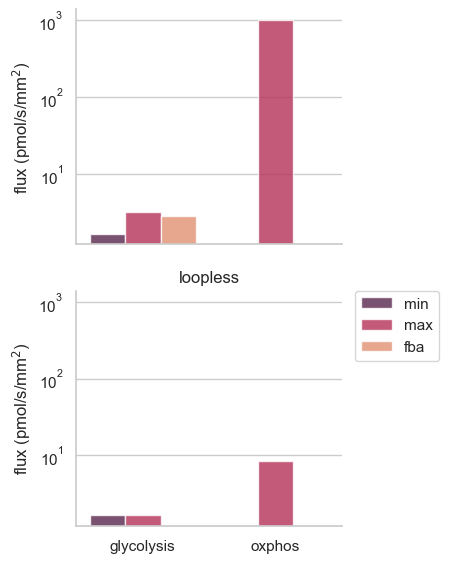

In [ ]:
# catplot oxphos_glycolysis_fva_fba_long
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# change order of bars in plot to Human1, Human1 (old), RPE, cone, rod make sure to have seperate bars for each datapoint
g = sns.catplot(
    data=oxphos_glycolysis_fva_fba_long, kind='bar', row='loopless', dodge=True,
    x="index", y="value", hue="type", hue_order=['min','max','fba'],
    order = ['MAR06916_PR','MAR04358_PR'],
        palette="rocket", alpha=.8, height=3,
)
g.despine(left=False)
g.set_axis_labels("","flux (pmol/s/mm$^{2}$)")
g.legend.set_title("")
# rotate x-axis labels
plt.tight_layout()
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plot title
plt.title('oxphos and glycolysis fluxes')
#log scale
plt.yscale('log')
#remove one legend
g._legend.remove()
# change tick axis names
g.set_xticklabels(['glycolysis','oxphos'])
# change subplot titles
g.set_titles(row_template = '{row_name}')

In [ ]:
oxphos_glycolysis_samples.T.to_clipboard()
#melt to long format
oxphos_glycolysis_samples_long = pd.melt(oxphos_glycolysis_samples.reset_index(),\
            id_vars=['index'], \
            value_vars=[0,1,2,3,4,5,6,7,8,9])
oxphos_glycolysis_samples_long  


,index,variable,value
0,MAR06916_PR,0,2.164382
1,MAR04358_PR,0,976.298501
2,MAR06916_PR,1,2.163735
3,MAR04358_PR,1,976.054682
4,MAR06916_PR,2,2.163625
5,MAR04358_PR,2,976.254276
6,MAR06916_PR,3,1.874698
7,MAR04358_PR,3,597.393986
8,MAR06916_PR,4,2.244510
9,MAR04358_PR,4,451.939082


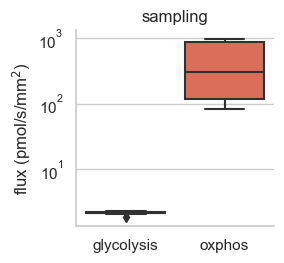

In [ ]:
# boxplot oxphos_glycolysis_samples_long as catplot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=oxphos_glycolysis_samples_long, kind='box', 
    x="index", y="value",
    order = ['MAR06916_PR','MAR04358_PR'],
        palette="rocket", height=3,
)   
# y log scale
plt.yscale('log')
title = 'oxphos and glycolysis fluxes'
plt.title(title)
# change tick axis names
g.set_xticklabels(['glycolysis','oxphos'])
# plot title
plt.title('sampling')
# y-axis label
plt.ylabel('flux (pmol/s/mm$^{2}$)')
# set figure height and width
plt.tight_layout()
# change x tick labels
g.set_xticklabels(['glycolysis','oxphos'])
# remove x title    
g.set_xlabels('')

In [ ]:
# get model from list with particular id
def get_mod_by_id(item_list, id):
    for item in item_list:
        if item.id == id:
            return item
m = get_mod_by_id(model_list, 'Human-GEM_28062023')
m

Name,Human-GEM_28062023
Memory address,2e93a467400
Number of metabolites,8499
Number of reactions,13085
Number of genes,2897
Number of groups,149
Objective expression,1.0*MAR03964 - 1.0*MAR03964_reverse_c9df9
Compartments,"Cytosol, Extracellular, Lysosome, Endoplasmic reticulum, Mitochondria, Peroxisome, Golgi apparatus, Nucleus, Inner mitochondria"


In [ ]:
def fba_analysis(mod, boundary_dicts, boundary_labels=dict(),results_name=''):    
    # inputs: model, list of boundary dicts {rxnID:(lb,ub)}, objective function rxnID (string)
    import pandas as pd
    from datetime import datetime
    from src.get_info import make_rxn_df, make_compact_rxn_df
    from datetime import datetime

    #  create empty dicts
    bounds = dict() # changed model bounds
    conditions = dict()
    ovs = dict() # objective values
    f = dict() # fba fluxes
    uptake = dict() # uptake fluxes
    secretion = dict() # secretion fluxes
        
    #   set counter, i, to 1
    i = 0
        
    with mod as m:
            
        # run analysis for every dict in list
        for d in boundary_dicts:
            for k in d:   # set bounds for all keys (rxnIDs in dict)
                m.reactions.get_by_id(k).bounds = d[k] # set bounds defined in dict

            # run analysis
            fba = m.optimize() # fba
            
            # objective values
            ovs[i] = [m.objective, m.objective.direction, fba.objective_value]
            
            if fba.status == 'optimal':

                # write analysis info / results into dicts

                # uptake / secretion
                uptake_summary = m.summary().uptake_flux
                secretion_summary = m.summary().secretion_flux
                uptake[i] = pd.DataFrame(uptake_summary['flux'])
                secretion[i] = pd.DataFrame(secretion_summary['flux'])
                
                # all fluxes
                f[i] = fba.to_frame()['fluxes']
          
            # update counter
            i=i+1
    
    # prepare dfs for excel sheet
    model_info = pd.DataFrame([m.id, m.name,m.compartments,m.annotation],\
             index=['id','name','compartments','annotation'],columns = ['model'])
    
    rxn_df = make_rxn_df(m)   
    compact_rxn_df = make_compact_rxn_df(m)  
    
    met_df = pd.DataFrame([[mi.name,mi.compartment,mi.formula,mi.charge,[r.id for r in list(mi.reactions)]] for mi in m.metabolites],\
             index=[m.id for m in m.metabolites],columns=['name','compartment','formula','charge','reactions'])
    
    ovs_df  = pd.concat([pd.DataFrame(boundary_dicts),\
                         pd.DataFrame(boundary_labels),\
                          pd.DataFrame(ovs, index=['objective','objective_direction','objective_value']).T],axis=1)
    
    # uptake / secretion dfs

    uptake_df = pd.concat(uptake,axis=1)
    secretion_df = pd.concat(secretion,axis=1)
    
    secretion_mets = pd.DataFrame([[met.name for met in m.reactions.get_by_id(mets).reactants] \
                                for mets in secretion_df.index],\
                               columns=['metabolite'],index= secretion_df.index)
    uptake_mets = pd.DataFrame([[met.name for met in m.reactions.get_by_id(mets).reactants] \
                                for mets in uptake_df.index],\
                               columns=['metabolite'],index= uptake_df.index)
    
    uptake_df = pd.merge(secretion_mets, uptake_df, left_index=True, right_index=True)  
    secretion_df = pd.merge(secretion_mets, secretion_df, left_index=True, right_index=True)  
                                     
    # sort uptake / secretion dfs
    uptake_df = uptake_df.reindex(uptake_df.fillna(0).sort_values(by=[c for c in secretion_df.columns if 'flux' in c],ascending=False).index)
    secretion_df = secretion_df.reindex(secretion_df.fillna(0).sort_values(by=[c for c in secretion_df.columns if 'flux' in c],ascending=True).index)
    
    # fluxes df
    fluxes_df = pd.concat([pd.DataFrame(f)],keys=["flux"],axis=1)
    fluxes_df = fluxes_df =pd.merge(compact_rxn_df, fluxes_df,left_index=True, right_index=True)
    # sort table on absolute flux size 
    fluxes_df= fluxes_df.reindex(fluxes_df[[c for c in fluxes_df.columns if 'flux' in c]].abs().sort_values(by=[c for c in fluxes_df.columns if 'flux' in c],ascending=False).index)
    fluxes_df[fluxes_df.index.isin([r.id for r in m.reactions if len(r.products)>0])]
    # select internal fluces only
    fluxes_df[fluxes_df.index.isin([r.id for r in m.reactions if len(r.products)>0])]
        
    # date stamp
    datestr = datetime.strftime(datetime.now(), '%H%M_%d-%m-%Y')   
    
    # write excel file
    with pd.ExcelWriter('fba_analysis_' + results_name + '_' + datestr + '.xlsx') as writer:  
        model_info.to_excel(writer, sheet_name = 'model')
        rxn_df.to_excel(writer, sheet_name = 'reactions')
        met_df.to_excel(writer, sheet_name = 'metabolites')
        ovs_df.to_excel(writer, sheet_name = 'objective_values')  
        uptake_df.to_excel(writer, sheet_name = 'uptake')    
        secretion_df.to_excel(writer, sheet_name = 'secretion')    
        fluxes_df.to_excel(writer, sheet_name = 'fluxes')     
        
    return [ovs_df, uptake_df, secretion_df, fluxes_df]

In [ ]:
# set objective function (ATP hydrolysis in PR for combined models)

for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)
